In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [26]:
data = pd.read_csv("../../data/gam_df.csv")

In [23]:
## source: https://gist.github.com/foowaa/5b20aebd1dff19ee024b6c72e14347bb
'''
numpy sinusoid position encoding of Transformer model.
params:
n_position(n):number of positions 
d_hid(m): dimension of embedding vector
padding_idx:set 0 dimension
return:
sinusoid_table(n*m):numpy array
'''
def get_sinusoid_encoding_table(n_position, d_hid, padding_idx=None):
    '''  '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_hid)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

   

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return sinusoid_table

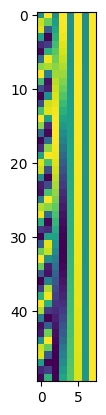

In [109]:
nstep = 50
ndim = 10
data = pd.read_csv("../../data/gam_df.csv")
pos_encodings = get_sinusoid_encoding_table(nstep, ndim)
plt.imshow(pos_encodings)

In [110]:
(pos_encodings @ pos_encodings.T).shape

(50, 50)

In [111]:
data.normalised_t.max()

1.0

In [112]:
X = []
y = []
for grp_key, grp in tqdm(data.groupby("file_index_word")):    
    grp = grp.assign(step=np.floor(grp.normalised_t/(1/(nstep-1))).astype("int32"))
    grp_steps = grp.groupby("step").agg(
        n=("pitch", "count"),
        norm_t=("normalised_t", "mean"),
        pitch=("pitch", "mean"))
    feat_vec = np.zeros(ndim)

    for step_i, row in grp_steps.iterrows():
        feat_vec += row.pitch * pos_encodings[step_i, :]
        # feat_vec[step_i] = row.pitch
    X.append(feat_vec)
    y.append(grp.word2.iloc[0])    

  0%|          | 0/2696 [00:00<?, ?it/s]

In [113]:
X = np.vstack(X)
X.shape

(2696, 8)

In [114]:
from sklearn.model_selection import train_test_split

In [115]:
trainX, testX, trainY, testY = train_test_split(
    X, y, 
    train_size=.9, 
    stratify=y, 
    random_state=12345)

In [125]:
from sklearn import svm
svc = svm.SVC(C=100)
svc.fit(trainX, trainY)

SVC(C=100)

In [126]:
svc.score(trainX, trainY)

0.1549876339653751

In [127]:
svc.score(testX, testY)

0.12222222222222222

In [108]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10, metric="minkowski", p=1)
knn.fit(trainX, trainY)
knn.score(testX, testY)

0.07777777777777778

In [85]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(trainX, trainY)
lsvc.score(testX, testY)

/Users/seantyh/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.02962962962962963

In [86]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(trainX, trainY)
lda.score(testX, testY)

0.14814814814814814

In [87]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(trainX, trainY)
qda.score(testX, testY)

/Users/seantyh/miniconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.15185185185185185

In [88]:
from sklearn.dummy import DummyClassifier
cls = DummyClassifier(strategy="most_frequent")
cls.fit(trainX, trainY)
cls.score(testX, testY)

0.08148148148148149